# Learned Tuner Evaluation

In [1]:
from copy import deepcopy
import os
import pathlib
import sys

In [2]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm.notebook import tqdm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import torch
import torchinfo

In [3]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lsm.cost import EndureCost
from endure.lsm.solver import QLSMSolver, ClassicSolver
from endure.lsm.types import Policy, System, LSMDesign
from endure.ltune.util import LTuneEvalUtil
from endure.ltune.model import LTuneModelBuilder

In [4]:
def save_fig(fig, filename):
    fig.savefig(os.path.join('/home/ndhuynh/transfer', filename), dpi=300, format='pdf', bbox_inches='tight')

# Loading Model

In [5]:
path = '/data/models/ltune/klsm/t20-v1/'
config = Reader.read_config(os.path.join(path, 'endure.toml'))
# config = Reader.read_config('../../endure.toml')
cf = EndureCost(config)
design_type = config['lsm']['design']
design_type

'KLSM'

In [6]:
model = LTuneModelBuilder(config).build_model()
model_name = os.path.join(path, 'best.model')
# model_name = os.path.join(path, 'checkpoints/epoch_10.checkpoint')
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
status = model.load_state_dict(model_params)
model.eval()
status

<All keys matched successfully>

In [7]:
torchinfo.summary(model, (1, len(config["ltune"]["input_features"])), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
KapLSMTuner                              [1, 421]                  --
├─BatchNorm1d: 1-1                       [1, 9]                    18
├─Linear: 1-2                            [1, 128]                  1,280
├─ReLU: 1-3                              [1, 128]                  --
├─Dropout: 1-4                           [1, 128]                  --
├─Sequential: 1-5                        [1, 128]                  --
│    └─Linear: 2-1                       [1, 128]                  16,512
│    └─Linear: 2-2                       [1, 128]                  16,512
│    └─Linear: 2-3                       [1, 128]                  16,512
│    └─Linear: 2-4                       [1, 128]                  16,512
├─Linear: 1-6                            [1, 128]                  16,512
├─Linear: 1-7                            [1, 1]                    129
├─Linear: 1-8                            [1, 128]            

# Util Module    

In [8]:
ltune_util = LTuneEvalUtil(config, model, design_type)

In [9]:
z0, z1, q, w = workload = ltune_util.gen._sample_workload(4)
system = ltune_util.gen._sample_system()
out = ltune_util.get_ltune_out(system, z0, z1, q, w)
design = ltune_util.convert_ltune_output(out)
out, design
# system

(tensor([[0.0197, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000

# Training Loss

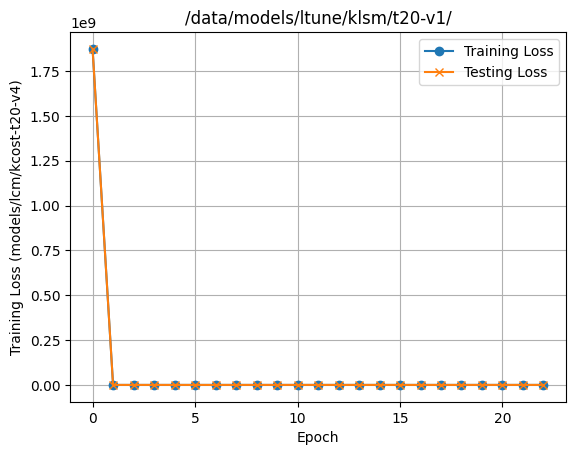

In [10]:
losses = pd.read_csv(os.path.join(path, 'losses.csv')).loc[0:]
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], '-o', label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], '-x', label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config["job"]["LTuneTrain"]["loss_fn_path"]})')
ax.set_title(f'{path}')
ax.grid()
_ = ax.legend()

In [11]:
losses.idxmin()

epoch          0
train_loss     8
test_loss     20
dtype: int64

# Evaluation

In [12]:
np.random.seed(0)
num_samples = 5000
default_sys = System()
table = []
for _ in tqdm(range(num_samples)):
    row = ltune_util.gen_sample_eval()
    table.append(row)

table = pd.DataFrame(table)

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/ndhuynh/miniconda3/envs/endure/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [13]:
table['delta_cost'] = (table['stune_cost'] - table['ltune_cost']) / table['stune_cost']
table['delta_loss'] = (table['stune_loss'] - table['ltune_loss']) / table['stune_loss']
table['stune_diff'] = (table['stune_cost'] - table['stune_loss']) / table['stune_cost']
table['ltune_diff'] = (table['ltune_cost'] - table['ltune_loss']) / table['ltune_cost']

In [14]:
wl_cols = ['z0', 'z1', 'q', 'w', 'H', 'N']
stune_cols = ['stune_h', 'stune_T', 'stune_level', 'stune_K']
ltune_cols = ['ltune_h', 'ltune_T', 'ltune_level', 'ltune_K']
cost_cols = ['stune_cost', 'stune_loss', 'ltune_cost', 'ltune_loss'] #, 'ltune_loss_direct']
delta_cols = ['delta_cost', 'delta_loss']
cols = wl_cols + stune_cols + ltune_cols + cost_cols + delta_cols
table.sort_values(by='ltune_level', ascending=False).head(20)[cols]

,z0,z1,q,w,H,N,stune_h,stune_T,stune_level,stune_K,ltune_h,ltune_T,ltune_level,ltune_K,stune_cost,stune_loss,ltune_cost,ltune_loss,delta_cost,delta_loss
902,0.474,0.205,0.044,0.277,5.148272,946313579,4.197324,6,6.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.199340,12,4.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.795655,1.952830,2.106608,2.069100,-0.173169,-0.059539
3240,0.579,0.092,0.060,0.269,6.289821,528638706,4.406439,8,5.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3.200027,12,4.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.164507,1.226792,1.274381,1.190493,-0.094352,0.029588
3188,0.327,0.221,0.011,0.441,5.053088,650017798,4.295331,4,7.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.146392,12,4.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.146211,1.420066,1.494345,1.318365,-0.303726,0.071617
83,0.830,0.090,0.048,0.032,6.813790,876088720,5.866662,16,4.0,"[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, ...",3.694517,13,4.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.537311,0.514589,0.629082,0.474912,-0.170797,0.077104
1176,0.260,0.261,0.081,0.398,6.417130,582355826,3.902312,7,5.0,"[1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, ...",1.902369,12,4.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.517737,1.575229,1.684359,1.495300,-0.109783,0.050742
2312,0.009,0.734,0.104,0.153,7.460280,216264369,2.302804,7,4.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3.157098,12,4.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.839962,1.816471,1.918464,1.885020,-0.042665,-0.037737
2466,0.437,0.264,0.019,0.280,5.401897,837501101,4.228408,5,6.0,"[2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.356116,12,4.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.366110,1.287136,2.000073,1.880328,-0.464065,-0.460862
2125,0.270,0.294,0.062,0.374,5.875936,662717215,3.061370,4,6.0,"[2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.208866,12,4.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3.079923,2.723077,4.522236,4.558235,-0.468295,-0.673928
4260,0.425,0.360,0.176,0.039,5.756408,107155396,3.531439,13,4.0,"[1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, ...",1.725037,12,4.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.866454,2.176736,1.954805,2.288982,-0.047336,-0.051566
1700,0.017,0.503,0.144,0.336,5.357357,422122729,1.098695,6,5.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.793063,12,4.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3.642392,3.809316,4.343281,4.191940,-0.192425,-0.100444


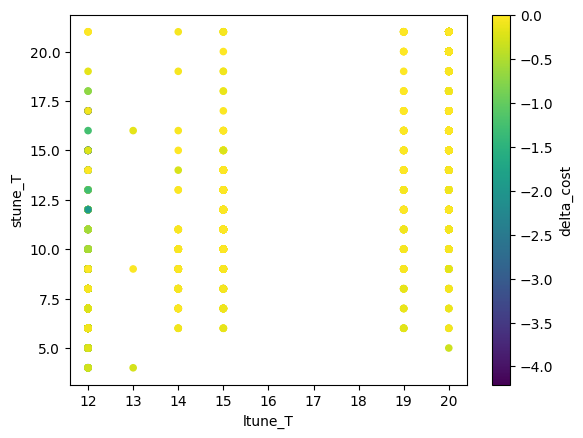

In [15]:
ax = table.plot.scatter(x='ltune_T', y='stune_T', c='delta_cost')

## Analytical Cost Model

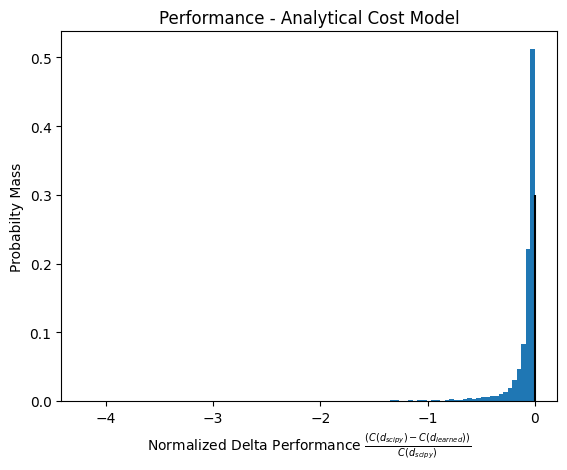

In [16]:
fig, ax = plt.subplots()
data = table['delta_cost']
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data), alpha=1, density=False, label='ACM', color='tab:blue')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Normalized Delta Performance $\\frac{(C(d_{scipy}) - C(d_{learned}))}{C(d_{scipy})}$')
ax.set_title('Performance - Analytical Cost Model')
ax.vlines(x=0, ymin=0, ymax=0.3, color='black')
# ax.vlines(x=-0.1, ymin=0, ymax=0.3, color='black')
# ax.legend()
plt.show()

Performance values within 5% cutoff

In [17]:
cutoff = 0.05
len(table[table.delta_cost > -0.05]) / len(table)

0.5786

Positive Performance Values

In [18]:
table[table.delta_cost > 0][cols]

,z0,z1,q,w,H,N,stune_h,stune_T,stune_level,stune_K,ltune_h,ltune_T,ltune_level,ltune_K,stune_cost,stune_loss,ltune_cost,ltune_loss,delta_cost,delta_loss
111,0.033,0.061,0.332,0.574,9.008105,647173659,0.200141,19,2.0,"[1, 1, 1, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.283769,20,2.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.194544,1.183585,1.194502,1.083808,0.000035,0.084301
176,0.019,0.268,0.381,0.332,14.708148,842553283,0.610600,19,2.0,"[1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.855285,20,2.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.144554,2.172918,2.144442,1.694145,0.000052,0.220336
563,0.121,0.495,0.125,0.259,5.676047,385223408,2.732816,18,3.0,"[1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.527009,20,2.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.960589,0.807079,0.960435,0.817188,0.000160,-0.012526
1990,0.025,0.111,0.454,0.410,15.112029,716860300,0.269912,18,2.0,"[1, 1, 1, 3, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.179532,20,2.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.533096,1.731336,1.533081,1.435020,0.000010,0.171149
2024,0.007,0.331,0.622,0.040,16.998493,573847544,0.000000,20,2.0,"[1, 1, 1, 3, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.071140,20,2.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.547720,3.321781,2.547713,2.348469,0.000003,0.293009
3665,0.028,0.059,0.344,0.569,18.476188,650765854,1.234134,19,2.0,"[1, 1, 1, 3, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.901904,20,2.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.044304,1.339437,1.044280,1.047796,0.000023,0.217734


## Learned Cost Model

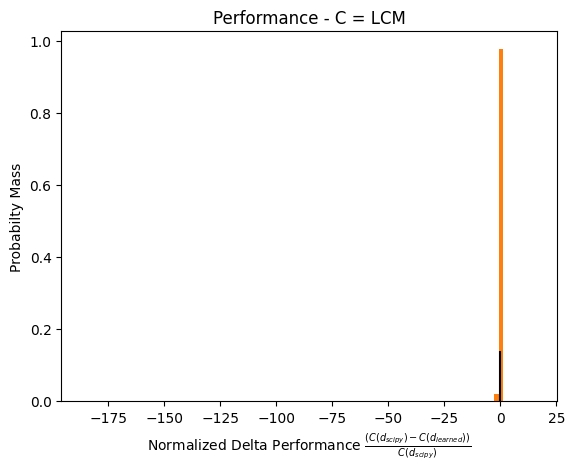

In [19]:
fig, ax = plt.subplots()
data = table['delta_loss']
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data), density=False, color='tab:orange')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Normalized Delta Performance $\\frac{(C(d_{scipy}) - C(d_{learned}))}{C(d_{scipy})}$')
ax.set_title('Performance - C = LCM')
ax.vlines(x=0, ymin=0, ymax=0.14, color='black')
plt.show()

## Difference in ACM and LCM

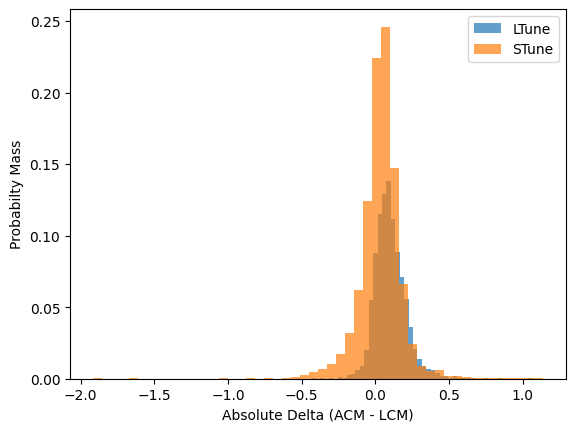

In [20]:
fig, ax = plt.subplots()
ldata = table['ltune_diff']
sdata = table['stune_diff']
ax.hist(ldata, weights=np.ones_like(ldata)/len(ldata), bins=50, alpha=0.7, label='LTune', color='tab:blue')
ax.hist(sdata, weights=np.ones_like(sdata)/len(sdata), bins=50, alpha=0.7, label='STune', color='tab:orange')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Absolute Delta (ACM - LCM)')
ax.legend()
plt.show()

In [21]:
table['ltune_mbuff'] = ((table['H'] - table['ltune_h']) * table['N']) / (1 * 1024 * 1024 * 1024 * 8)

## Workload Correlations

In [22]:
def plot_workload_trend(df, trend='stune_T'):
    fig = plt.figure(figsize=(5,5))
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0.5]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads', labelpad=6)
    ax.set_ylabel('Range-Reads', labelpad=6)
    ax.set_zlabel('Writes', labelpad=6)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc, pad=0.11, shrink=0.6)
    cbar.set_label(trend)
    cbar.ax.tick_params(labelsize=12)
    font = {'size': 12}
    ax.tick_params('x', labelsize=font['size'])
    ax.tick_params('y', labelsize=font['size'])
    ax.tick_params('z', labelsize=font['size'])
    
    return fig, ax, sc, cbar

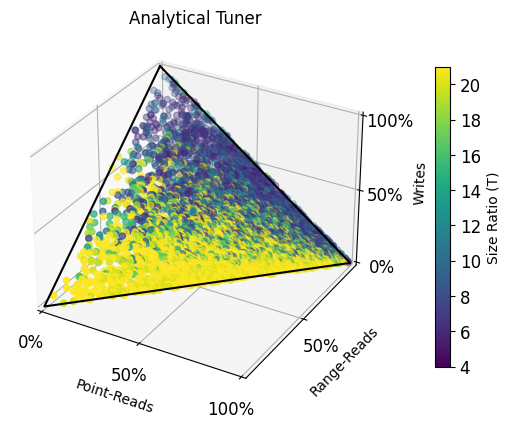

In [23]:
# plt.rcParams.update({'font.size': 18})
fig, ax, sc, cbar = plot_workload_trend(table, trend='stune_T')
cbar.set_label('Size Ratio (T)')
ax.set_title('Analytical Tuner')
plt.show()
# save_fig(fig, 'analytical_tuner_size_ratio.pdf')

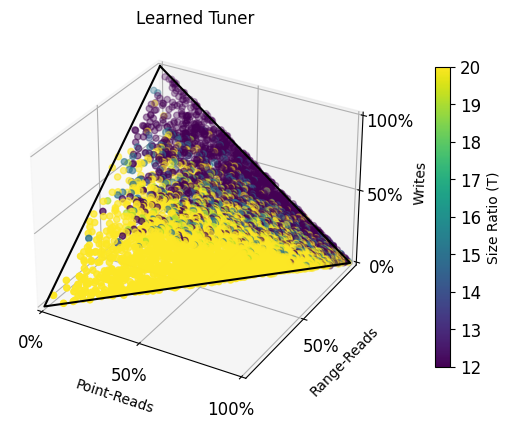

In [24]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='ltune_T')
ax.set_title('Learned Tuner')
cbar.set_label('Size Ratio (T)')
plt.show()
# save_fig(fig, 'learned_tuner_size_ratio.pdf')

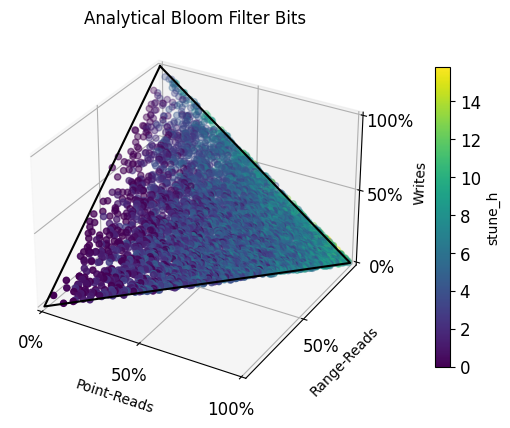

In [25]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='stune_h')
ax.set_title('Analytical Bloom Filter Bits')
plt.show()

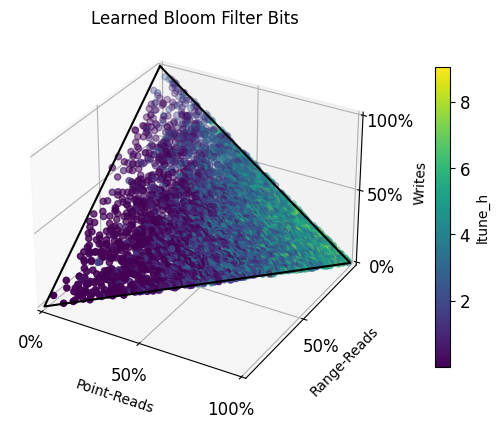

In [26]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='ltune_h')
ax.set_title('Learned Bloom Filter Bits')
plt.show()

In [27]:
# fig, ax, sc, cbar = plot_workload_trend(table, trend='stune_Q')
# ax.set_title('Analytical')
# plt.show()

In [28]:
# fig, ax, sc, cbar = plot_workload_trend(table, trend='ltune_Q')
# ax.set_title('Learned')
# plt.show()

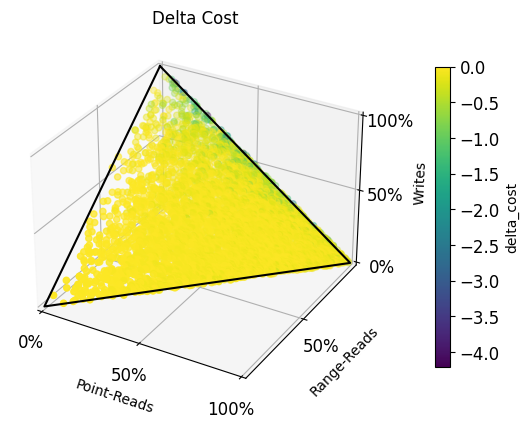

In [29]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='delta_cost')
ax.set_title('Delta Cost')
plt.show()

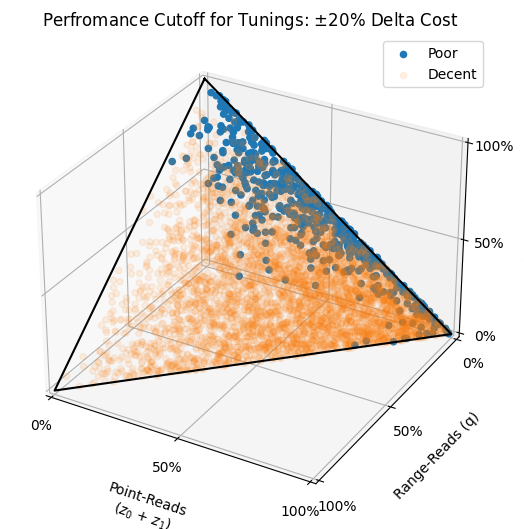

In [30]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
ax.set_ylabel('Range-Reads (q)', labelpad=10)
ax.set_zlabel('Writes (w)', labelpad=10)

cutoff = (0.2)
groupa = table[(table['delta_cost'] > -cutoff)]
groupb = table[(table['delta_cost'] < -cutoff)]
ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label='Poor', alpha=1)
ax.scatter(groupa['z0'] + groupa['z1'], groupa['q'], groupa['w'], label='Decent', alpha=0.1)
ax.set_title(f'Perfromance Cutoff for Tunings: $\pm${cutoff:.0%} Delta Cost')
ax.legend()
plt.show()

## 

In [56]:
t = pd.DataFrame(table['ltune_K'].tolist())
t.sort_values(by=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3326,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3325,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3324,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3323,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4810,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4050,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
11,1,7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [57]:
table.iloc[1963]

z0                                                               0.012
z1                                                               0.141
q                                                                0.034
w                                                                0.813
B                                                                 16.0
s                                                                  0.0
E                                                                 2048
H                                                            17.742065
N                                                            989577486
stune_policy                                                         2
stune_h                                                       4.974787
stune_T                                                              8
stune_level                                                        3.0
stune_cost                                                    0.886877
stune_

## 